## Foundational Text classification with Python

In [1]:
import sys
print(sys.version)

3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0]


In [2]:
import sklearn
import pandas as pd

import wordcloud
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import metrics

#### Copy files to local FS from GCP bucket

## Part 1: Representing text as numerical data

In [3]:
# example text for model training (citation messages)
simple_train = ['The University of Chicago', \
                'private research university in Chicago', \
                'culturally rich and ethnically diverse coeducational research university', \
                'Chicago Chicago Chicago Chicago']

In [4]:
simple_train

['The University of Chicago',
 'private research university in Chicago',
 'culturally rich and ethnically diverse coeducational research university',
 'Chicago Chicago Chicago Chicago']

From the [scikit-learn documentation](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_extraction.text):

> Text Analysis is a major application field for machine learning algorithms. However the raw data, a sequence of symbols cannot be fed directly to the algorithms themselves as most of them expect **numerical feature vectors with a fixed size** rather than the **raw text documents with variable length**.

In scikit-learn we have a choice of four different feature extraction mechanisms:
* CountVectorizer - Convert a collection of text documents to a matrix of token counts
* HashingVectorizer - Convert a collection of text documents to a matrix of token occurrences
* TfidfTransformer - Transform a count matrix to a normalized TF or TF-IDF representation
* TfidfVectorizer - Convert a collection of raw documents to a matrix of TF-IDF features.  Equivalent to CountVectorizer followed by TfidfTransformer

### CountVectorizer

In [5]:
countvectorizer = CountVectorizer()
countvectorizer_matrix = countvectorizer.fit_transform(simple_train)
countvectorizer_matrix.shape

(4, 13)

In [6]:
countvectorizer_matrix_df = pd.DataFrame(countvectorizer_matrix.toarray(), columns=countvectorizer.get_feature_names_out())
countvectorizer_matrix_df

,and,chicago,coeducational,culturally,diverse,ethnically,in,of,private,research,rich,the,university
0,0,1,0,0,0,0,0,1,0,0,0,1,1
1,0,1,0,0,0,0,1,0,1,1,0,0,1
2,1,0,1,1,1,1,0,0,0,1,1,0,1
3,0,4,0,0,0,0,0,0,0,0,0,0,0


From the [scikit-learn documentation](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction):

> In this scheme, features and samples are defined as follows:

> - Each individual token occurrence frequency (normalized or not) is treated as a **feature**.
> - The vector of all the token frequencies for a given document is considered a multivariate **sample**.

> A **corpus of documents** can thus be represented by a matrix with **one row per document** and **one column per token** (e.g. word) occurring in the corpus.

> We call **vectorization** the general process of turning a collection of text documents into numerical feature vectors. This specific strategy (tokenization, counting and normalization) is called the **Bag of Words** or "Bag of n-grams" representation. Documents are described by word occurrences while completely ignoring the relative position information of the words in the document.

#### Removing stop-words from CountVectorizer

In [7]:
countvectorizer = CountVectorizer(stop_words='english')
countvectorizer_matrix = countvectorizer.fit_transform(simple_train)
countvectorizer_matrix.shape

(4, 9)

In [8]:
countvectorizer_matrix_df = pd.DataFrame(countvectorizer_matrix.toarray(), columns=countvectorizer.get_feature_names_out())
countvectorizer_matrix_df

,chicago,coeducational,culturally,diverse,ethnically,private,research,rich,university
0,1,0,0,0,0,0,0,0,1
1,1,0,0,0,0,1,1,0,1
2,0,1,1,1,1,0,1,1,1
3,4,0,0,0,0,0,0,0,0


#### Adding N-Gram features to CountVectorizer
word = word n-grams  
char = char n-grams  
char_wb = creates character n-grams only from text inside word boundaries; n-grams at the edges of words are padded with space.

In [9]:
countvectorizer = CountVectorizer(analyzer='word', ngram_range=(1,3))
#countvectorizer = CountVectorizer(analyzer='char', ngram_range=(1,3))
#countvectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(1,3))
countvectorizer_matrix = countvectorizer.fit_transform(simple_train)
countvectorizer_matrix.shape

(4, 39)

In [10]:
countvectorizer_matrix_df = pd.DataFrame(countvectorizer_matrix.toarray(), columns=countvectorizer.get_feature_names_out())
countvectorizer_matrix_df

,and,and ethnically,and ethnically diverse,chicago,chicago chicago,chicago chicago chicago,coeducational,coeducational research,coeducational research university,culturally,...,rich and,rich and ethnically,the,the university,the university of,university,university in,university in chicago,university of,university of chicago
0,0,0,0,1,0,0,0,0,0,0,...,0,0,1,1,1,1,0,0,1,1
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
2,1,1,1,0,0,0,1,1,1,1,...,1,1,0,0,0,1,0,0,0,0
3,0,0,0,4,3,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Controlling features in CountVectorizer

max_df: When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words). If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.  
**When building the vocabulary, it ignores terms that have a document frequency strictly higher than the given threshold. This could be used to exclude terms that are too frequent and are unlikely to help predict the label. For example, by analyzing reviews on the movie Lion King, the term 'Lion' might appear in 90% of the reviews (documents), in which case, we could consider establishing Max_df=0.89**  

min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.  
**Min_df ignores terms that have a document frequency (presence in % of documents) strictly lower than the given threshold. For example, Min_df=0.66 requires that a term appear in 66% of the documents for it to be considered part of the vocabulary.**    


max_features: If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.

In [11]:
countvectorizer = CountVectorizer(lowercase=False, stop_words='english',
                                  max_df=0.8, min_df=0.2, max_features=1000, ngram_range=(1,3))
countvectorizer_matrix = countvectorizer.fit_transform(simple_train)
countvectorizer_matrix.shape

(4, 31)

In [12]:
countvectorizer_matrix_df = pd.DataFrame(countvectorizer_matrix.toarray(), columns=countvectorizer.get_feature_names_out())
countvectorizer_matrix_df

,Chicago,Chicago Chicago,Chicago Chicago Chicago,The,The University,The University Chicago,University,University Chicago,coeducational,coeducational research,...,private research,private research university,research,research university,research university Chicago,rich,rich ethnically,rich ethnically diverse,university,university Chicago
0,1,0,0,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,0,0,0,1,1
2,0,0,0,0,0,0,0,0,1,1,...,0,0,1,1,0,1,1,1,1,0
3,4,3,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### HashingVectorizer
The HashingVectorizer has a parameter n_features which is 2^20 = 1048576 by default. When hashing, they don't actually compute a dictionary mapping terms to a unique index to use for each one. Instead, you just hash each term and use a large enough size that you don't expect there to be too many collisions

It turns a collection of text documents into a scipy.sparse matrix holding token occurrence counts (or binary occurrence information), possibly normalized as token frequencies if norm=’l1’ or projected on the euclidean unit sphere if norm=’l2’

In [13]:
hashingvectorizer = HashingVectorizer(n_features=15)
hashingvectorizer_matrix = hashingvectorizer.fit_transform(simple_train)
hashingvectorizer_matrix.shape

(4, 15)

In [14]:
hashingvectorizer_matrix_df = pd.DataFrame(hashingvectorizer_matrix.toarray())
hashingvectorizer_matrix_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.707107,0.000000,0.0,0.0,0.0,0.0,0.0,-0.707107,0.000000
1,0.0,0.0,0.0,0.577350,0.000000,0.000000,0.000000,-0.577350,0.0,0.0,0.0,0.0,0.0,-0.577350,0.000000
2,0.0,0.0,0.0,0.316228,-0.316228,-0.632456,0.316228,-0.316228,0.0,0.0,0.0,0.0,0.0,0.316228,0.316228
3,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,-1.000000,0.000000


### TfidfVectorizer

In [15]:
tfidfvectorizer = TfidfVectorizer(stop_words='english')
tfidfvectorizer_matrix = tfidfvectorizer.fit_transform(simple_train)
tfidfvectorizer_matrix.shape

(4, 9)

In [16]:
tfidfvectorizer_matrix_df = pd.DataFrame(tfidfvectorizer_matrix.toarray(), columns=tfidfvectorizer.get_feature_names_out())
tfidfvectorizer_matrix_df

,chicago,coeducational,culturally,diverse,ethnically,private,research,rich,university
0,0.707107,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.707107
1,0.408922,0.000000,0.000000,0.000000,0.000000,0.640655,0.505100,0.000000,0.408922
2,0.000000,0.407265,0.407265,0.407265,0.407265,0.000000,0.321093,0.407265,0.259952
3,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Part 2.  Fitting vocabulary of the training data

In [17]:
# instantiate CountVectorizer (we will use default parameters)
countvectorizer = CountVectorizer()
# learn the 'vocabulary' of the training data (occurs in-place)
countvectorizer.fit(simple_train)

CountVectorizer()

In [18]:
# examine the fitted vocabulary
countvectorizer.get_feature_names_out()

array(['and', 'chicago', 'coeducational', 'culturally', 'diverse',
       'ethnically', 'in', 'of', 'private', 'research', 'rich', 'the',
       'university'], dtype=object)

In [19]:
# example text for model testing
simple_test = ["University of Chicago is a private institution"]

In order to **make a prediction**, the new observation must have the **same features as the training observations**, both in number and meaning.

In [20]:
# transform testing data into a document-term matrix (using existing vocabulary)
simple_test_matrix = countvectorizer.transform(simple_test)
simple_test_matrix.toarray()

array([[0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1]])

In [21]:
simple_test_matrix_df = pd.DataFrame(simple_test_matrix.toarray(), columns=countvectorizer.get_feature_names_out())
simple_test_matrix_df

,and,chicago,coeducational,culturally,diverse,ethnically,in,of,private,research,rich,the,university
0,0,1,0,0,0,0,0,1,1,0,0,0,1


**Summary:**

- `vect.fit(train)` **learns the vocabulary** of the training data
- `vect.transform(train)` uses the **fitted vocabulary** to build a document-term matrix from the training data
- `vect.transform(test)` uses the **fitted vocabulary** to build a document-term matrix from the testing data (and **ignores tokens** it hasn't seen before)

## Part 3: Reading a text-based dataset into pandas

In [22]:
# read file into pandas using a relative path
directory = 'https://storage.googleapis.com/msca-bdp-data-open/md_traffic/'
fileName = 'md_traffic_full.csv'

path = directory + fileName

citation = pd.read_table(path, skiprows=1, header=None, sep=',', names=['description', 'violation'])
citation.shape

(790282, 2)

#### Balance samples

In [23]:
citation.groupby("violation").count()

,description
violation,
Citation,377229
ESERO,46987
SERO,26
Warning,366035


In [24]:
citation = citation[citation['violation'] != 'SERO']
citation = citation.groupby("violation").sample(n=10000, random_state=1)
citation.reset_index(inplace=True, drop=True)
citation.groupby("violation").count()

,description
violation,
Citation,10000
ESERO,10000
Warning,10000


In [25]:
pd.set_option('display.max_colwidth', None)

In [26]:
citation.sample(n=5, random_state=1)

,description,violation
10747,Stop Lights,ESERO
12573,Headlights (*),ESERO
29676,DRIVER FAILURE TO STOP AT STOP SIGN LINE,Warning
8856,DRIVING VEHICLE ON HIGHWAY WITH SUSPENDED REGISTRATION,Citation
21098,FAILURE TO DISPLAY REGISTRATION CARD UPON DEMAND BY POLICE OFFICER,Warning


In [27]:
# convert label to a binary numerical variable
citation['violation_flag'] = citation.violation.map({'Warning':0, 'Citation':1, 'ESERO':2})

In [28]:
# check that the conversion worked
citation.sample(n=5, random_state=1)

,description,violation,violation_flag
10747,Stop Lights,ESERO,2
12573,Headlights (*),ESERO,2
29676,DRIVER FAILURE TO STOP AT STOP SIGN LINE,Warning,0
8856,DRIVING VEHICLE ON HIGHWAY WITH SUSPENDED REGISTRATION,Citation,1
21098,FAILURE TO DISPLAY REGISTRATION CARD UPON DEMAND BY POLICE OFFICER,Warning,0


In [29]:
# define X and y
X = citation.description
y = citation.violation_flag

print(f"X Shape: {X.shape}")
print(f"y Shape: {y.shape}")

X Shape: (30000,)
y Shape: (30000,)


In [30]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(f"Training records, X_train: {X_train.shape} y_train: {y_train.shape}")
print(f"Testing records, X_test: {X_test.shape} y_test: {y_test.shape}")

Training records, X_train: (22500,) y_train: (22500,)
Testing records, X_test: (7500,) y_test: (7500,)


## Part 3: Vectorizing our dataset

In [31]:
# instantiate the vectorizer
vect = CountVectorizer()

In [32]:
# learn training data vocabulary, then use it to create a document-term matrix
vect.fit(X_train)
X_train_dtm = vect.transform(X_train)

In [33]:
# combine fit and transform into a single step
X_train_dtm = vect.fit_transform(X_train)

In [34]:
# examine the document-term matrix
X_train_dtm

<22500x998 sparse matrix of type '<class 'numpy.int64'>'
	with 153693 stored elements in Compressed Sparse Row format>

In [35]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
X_test_dtm

<7500x998 sparse matrix of type '<class 'numpy.int64'>'
	with 51205 stored elements in Compressed Sparse Row format>

## Part 4: Building and evaluating models

### Naive Bayes Model

In [36]:
# instantiate a Multinomial Naive Bayes model
nb = MultinomialNB()

In [37]:
# train and time the model using X_train_dtm
%time nb.fit(X_train_dtm, y_train)

CPU times: user 3.25 ms, sys: 7.01 ms, total: 10.3 ms
Wall time: 8.09 ms


MultinomialNB()

In [38]:
# make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

In [39]:
# calculate accuracy of class predictions
print(f"Test Accuracy: {metrics.accuracy_score(y_test, y_pred_class) * 100:.1f}%")

Test Accuracy: 83.3%


In [40]:
# calculate precision and recall
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.72      0.80      0.76      2456
           1       0.79      0.70      0.74      2546
           2       1.00      1.00      1.00      2498

    accuracy                           0.83      7500
   macro avg       0.83      0.83      0.83      7500
weighted avg       0.84      0.83      0.83      7500



In [41]:
# calculate the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred_class))

[[1969  483    4]
 [ 766 1780    0]
 [   3    0 2495]]


#### Most important features

In [42]:
clf = nb


feature_names = vect.get_feature_names_out()
coefs_with_fns = zip(feature_names, clf.coef_[0])

coefs_with_fns_df = pd.DataFrame(coefs_with_fns,
                    columns=['feature', 'coefficient'])

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


In [43]:
coefs_with_fns_df.sort_values(by='coefficient', ascending=False, inplace=True)
coefs_with_fns_df.head(10)

,feature,coefficient
888,to,-2.795057
374,failure,-3.060750
633,of,-3.355238
319,driver,-3.505306
638,on,-3.625392
941,vehicle,-3.800684
322,driving,-3.875743
846,stop,-3.925600
756,registration,-3.927001
939,veh,-3.983995


In [44]:
coefs_with_fns_df.sort_values(by='coefficient', ascending=True, inplace=True)
coefs_with_fns_df.head(10)

,feature,coefficient
0,10,-11.18963
929,up,-11.18963
86,82,-11.18963
87,84,-11.18963
89,87,-11.18963
90,88,-11.18963
91,89,-11.18963
922,unopened,-11.18963
943,vehicles,-11.18963
93,92,-11.18963


### Logistic Regression Model

In [45]:
# instantiate a logistic regression model
logreg = LogisticRegression(max_iter=10000)

In [46]:
# train the model using X_train_dtm
%time logreg.fit(X_train_dtm, y_train)

CPU times: user 2.23 s, sys: 0 ns, total: 2.23 s
Wall time: 2.23 s


LogisticRegression(max_iter=10000)

In [47]:
# make class predictions for X_test_dtm
y_pred_class = logreg.predict(X_test_dtm)

In [48]:
# calculate accuracy of class predictions
print(f"Test Accuracy: {metrics.accuracy_score(y_test, y_pred_class) * 100:.1f}%")

Test Accuracy: 84.8%


In [49]:
# calculate precision and recall
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.72      0.87      0.79      2456
           1       0.85      0.68      0.75      2546
           2       1.00      1.00      1.00      2498

    accuracy                           0.85      7500
   macro avg       0.86      0.85      0.85      7500
weighted avg       0.86      0.85      0.85      7500



In [50]:
# calculate the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred_class))

[[2138  312    6]
 [ 822 1724    0]
 [   1    0 2497]]


#### Most important Features

In [51]:
clf = logreg


feature_names = vect.get_feature_names_out()
coefs_with_fns = zip(feature_names, clf.coef_[0])

coefs_with_fns_df = pd.DataFrame(coefs_with_fns,
                    columns=['feature', 'coefficient'])

In [52]:
coefs_with_fns_df.sort_values(by='coefficient', ascending=True, inplace=True)
coefs_with_fns_df.head(10)

,feature,coefficient
577,maximum,-2.404326
122,alcohol,-1.706167
435,headlights,-1.532796
549,lights,-1.399314
871,taillights,-1.350348
991,workzone,-1.224632
477,influence,-1.132041
272,damage,-1.041479
839,standing,-1.021402
416,glass,-0.973661


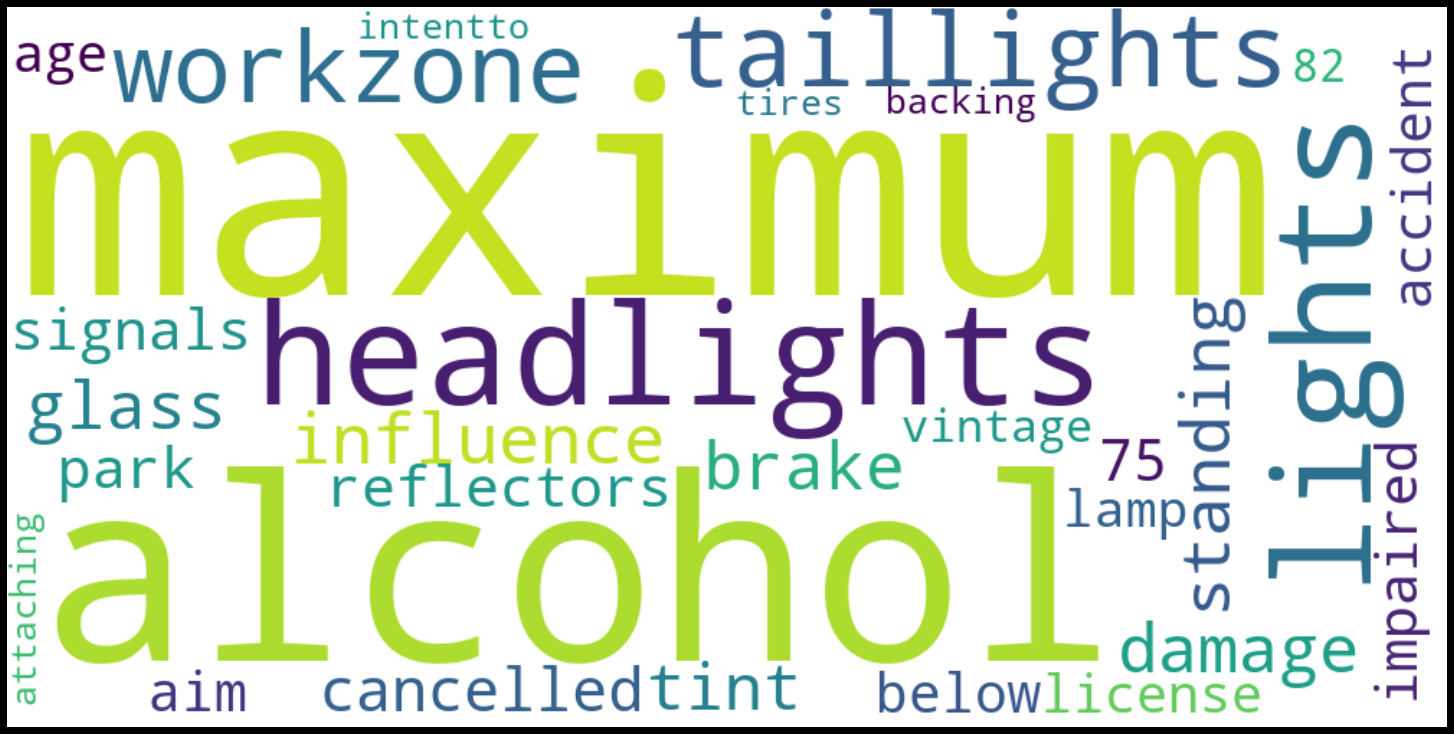

In [53]:
top_features_df = coefs_with_fns_df.copy()
top_features_df['coefficient'] = top_features_df['coefficient']*(-10)

data = dict(zip(top_features_df['feature'].tolist(), top_features_df['coefficient'].tolist()))


wordcloud_obj = wordcloud.WordCloud(
    width = 1000,
    height = 500,
    background_color = 'white',
    max_words=30,
    stopwords = wordcloud.STOPWORDS)

wordcloud_obj.generate_from_frequencies(data)

fig = plt.figure(
    figsize = (20, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud_obj, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [54]:
coefs_with_fns_df.sort_values(by='coefficient', ascending=False, inplace=True)
coefs_with_fns_df.head(10)

,feature,coefficient
550,limit,1.860901
488,inoperative,1.814737
859,susp,1.494700
355,equipment,1.406053
878,the,1.231994
939,veh,1.183606
469,inadequate,1.117062
888,to,1.083974
487,inoperable,1.057508
546,light,1.047284


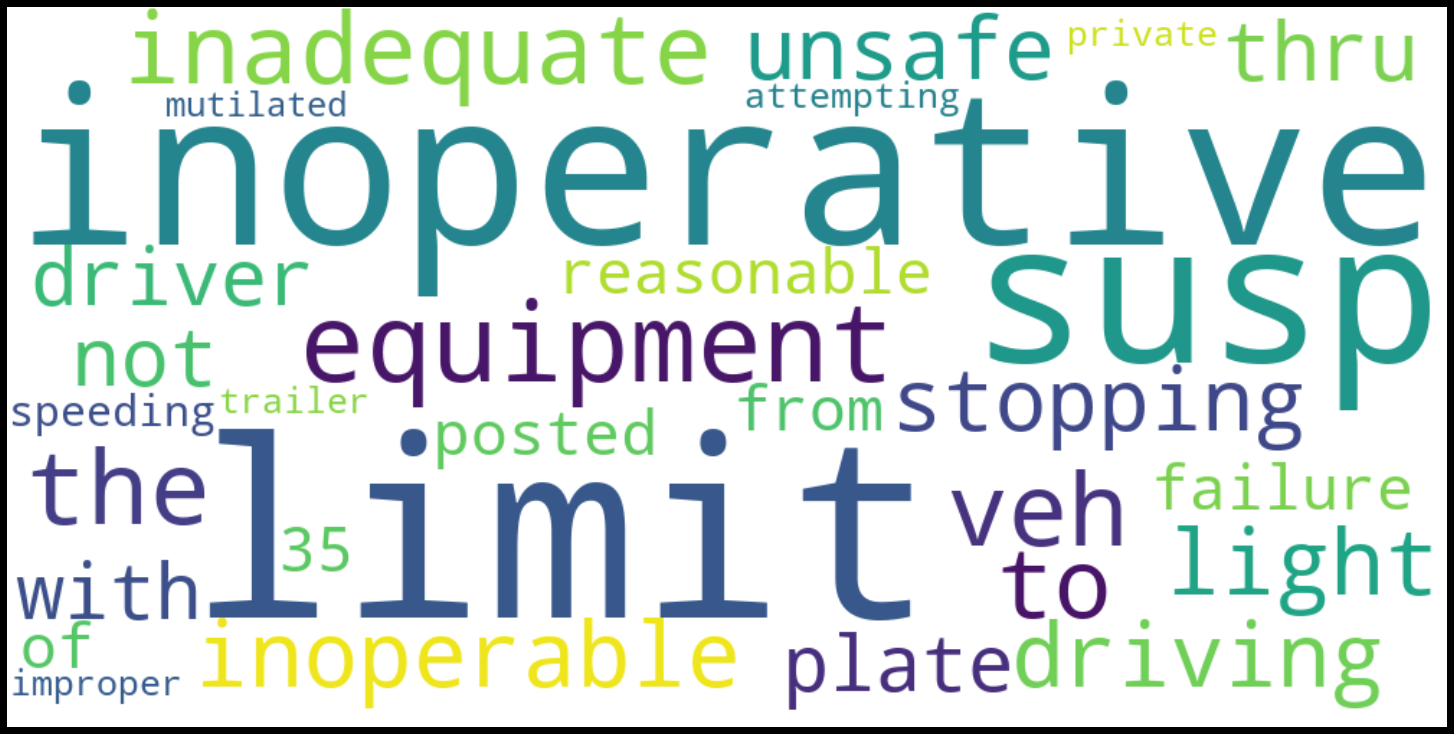

In [55]:
top_features_df = coefs_with_fns_df
top_features_df['coefficient'] = top_features_df['coefficient']*(10)

data = dict(zip(top_features_df['feature'].tolist(), top_features_df['coefficient'].tolist()))


wordcloud_obj = wordcloud.WordCloud(
    width = 1000,
    height = 500,
    background_color = 'white',
    max_words=30,
    stopwords = wordcloud.STOPWORDS)

wordcloud_obj.generate_from_frequencies(data)

fig = plt.figure(
    figsize = (20, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud_obj, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### Support Vector Machine

In [56]:
# instantiate a SVM model
svm = SGDClassifier(max_iter=100, tol=None)

In [57]:
# train the model using X_train_dtm
%time svm.fit(X_train_dtm, y_train)

CPU times: user 467 ms, sys: 184 µs, total: 467 ms
Wall time: 466 ms


SGDClassifier(max_iter=100, tol=None)

In [58]:
# make class predictions for X_test_dtm
y_pred_class = svm.predict(X_test_dtm)

In [59]:
# calculate accuracy of class predictions
print(metrics.accuracy_score(y_test, y_pred_class))

0.8486666666666667


In [60]:
# calculate precision and recall
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.72      0.87      0.79      2456
           1       0.85      0.68      0.75      2546
           2       1.00      1.00      1.00      2498

    accuracy                           0.85      7500
   macro avg       0.86      0.85      0.85      7500
weighted avg       0.86      0.85      0.85      7500



In [61]:
# calculate the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred_class))

[[2143  309    4]
 [ 821 1725    0]
 [   1    0 2497]]


## Part 5: Improving model performance

In [62]:
# show default parameters for CountVectorizer
countvectorizer

CountVectorizer()

In [63]:
# remove English stop words
countvectorizer = CountVectorizer(stop_words='english')

- **ngram_range:** tuple (min_n, max_n), default=(1, 1)
    - The lower and upper boundary of the range of n-values for different n-grams to be extracted.
    - All values of n such that min_n <= n <= max_n will be used.

In [64]:
# include n-grams
countvectorizer = CountVectorizer(ngram_range=(1, 3))

- **max_df:** float in range [0.0, 1.0] or int, default=1.0
    - When building the vocabulary, ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words).
    - If float, the parameter represents a proportion of documents.
    - If integer, the parameter represents an absolute count.

In [65]:
# ignore terms that appear in more than 50% of the documents
countvectorizer = CountVectorizer(max_df=0.5)

- **min_df:** float in range [0.0, 1.0] or int, default=1
    - When building the vocabulary, ignore terms that have a document frequency strictly lower than the given threshold. (This value is also called "cut-off" in the literature.)
    - If float, the parameter represents a proportion of documents.
    - If integer, the parameter represents an absolute count.

In [66]:
# only keep terms that appear in at least 2 documents
countvectorizer = CountVectorizer(min_df=2)

## Part 6.  Troubleshooting results
Focus on predictions with low confidence level

In [67]:
X_test_df = pd.DataFrame(X_test)
X_test_df.reset_index(inplace=True, drop=True)

y_test_df = pd.DataFrame(y_test)
y_test_df.reset_index(inplace=True, drop=True)

#### Scoring the test results and appending both class and probabilities

In [68]:
y_pred_prob = logreg.predict_proba(X_test_dtm)
y_pred_class = logreg.predict(X_test_dtm)

In [69]:
y_pred_prob_df = pd.DataFrame(y_pred_prob)
y_pred_prob_df.columns = ['0-prob', '1-prob', '2-prob']

y_pred_class_df = pd.DataFrame(y_pred_class)
y_pred_class_df.columns = ['predicted']

#### Combining the results and focusing on low confidence levels

In [70]:
results_df = X_test_df.join(y_test_df).join(y_pred_class_df).join(y_pred_prob_df)

In [71]:
results_review_df = results_df[(results_df['0-prob'] < 0.6) & (results_df['1-prob'] < 0.6) & (results_df['2-prob'] < 0.6)]
results_review_df.shape

(866, 6)

In [72]:
pd.set_option('display.max_colwidth', None)

In [73]:
results_review_df.head(10)

,description,violation_flag,predicted,0-prob,1-prob,2-prob
3,DRIVING VEHICLE ON HIGHWAY WITH SUSPENDED REGISTRATION,1,0,0.508935,0.491042,2.277219e-05
9,DISPLAYING EXPIRED REGISTRATION PLATE ISSUED BY ANY STATE,0,0,0.542408,0.456785,8.071975e-04
11,DRIVING VEHICLE ON HIGHWAY WITH SUSPENDED REGISTRATION,0,0,0.508935,0.491042,2.277219e-05
20,FAILURE VEH. TO YIELD INTERSECTION RIGHT-OF-WAY TO ANOTHER VEH.,1,0,0.576174,0.423826,2.123339e-08
26,DISPLAYING EXPIRED REGISTRATION PLATE ISSUED BY ANY STATE,0,0,0.542408,0.456785,8.071975e-04
33,DRIVING VEHICLE ON HIGHWAY WITH SUSPENDED REGISTRATION,1,0,0.508935,0.491042,2.277219e-05
42,DRIVER USING HANDS TO USE HANDHELD TELEPHONE WHILEMOTOR VEHICLE IS IN MOTION,0,1,0.495440,0.504353,2.073549e-04
48,DRIVING VEHICLE ON HIGHWAY WITHOUT CURRENT REGISTRATION PLATES AND VALIDATION TABS,0,0,0.583096,0.416860,4.425582e-05
60,DRIVER USING HANDS TO USE HANDHELD TELEPHONE WHILEMOTOR VEHICLE IS IN MOTION,1,1,0.495440,0.504353,2.073549e-04
61,DRIVING VEHICLE ON HIGHWAY WITH SUSPENDED REGISTRATION,0,0,0.508935,0.491042,2.277219e-05


In [74]:
import datetime
import pytz

datetime.datetime.now(pytz.timezone('US/Central')).strftime("%a, %d %B %Y %H:%M:%S")

'Sat, 22 October 2022 13:26:07'